# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
#altri import futuri

Caricamento del dataset

In [2]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
dataset.head()

encounter_id  patient_id  hospital_id   age    bmi  elective_surgery  \
0         66154       25312          118  68.0  22.73                 0   
1        114252       59342           81  77.0  27.42                 0   
2        119783       50777          118  25.0  31.95                 0   
3         79267       46918          118  81.0  22.64                 1   
4         92056       34377           33  19.0    NaN                 0   

   ethnicity gender  height           icu_admit_source  ...  \
0  Caucasian      M   180.3                      Floor  ...   
1  Caucasian      F   160.0                      Floor  ...   
2  Caucasian      F   172.7       Accident & Emergency  ...   
3  Caucasian      F   165.1  Operating Room / Recovery  ...   
4  Caucasian      M   188.0       Accident & Emergency  ...   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0             Metabolic            Metabolic   
3                          0.0        Cardiovascular       Cardiovascular   
4                          0.0                Trauma               Trauma   

   Unnamed: 83  hospital_death  
0          NaN               0  
1          NaN               0  
2          NaN               0  
3          NaN               0  
4          NaN               0  

[5 rows x 85 columns]

# Data Exploration

## Class Balancing

Siamo interessati a classificare i pazienti ricoverati come 'in pericolo di vita' oppure 'in salute'. Per questo motivo identifichiamo le due classi di interesse a partire dalla colonna ```hospital_death``` del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset.

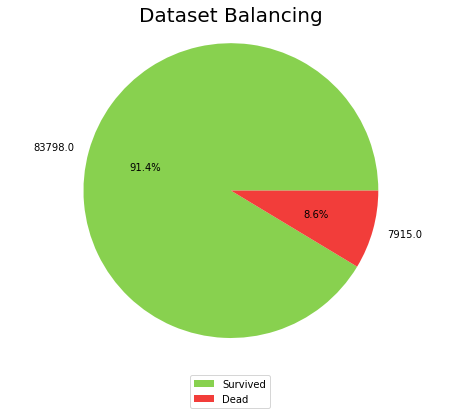

In [3]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Come possiamo vedere il dataset è altamente sbilanciato. Infatti abbiamo il 91.4% di righe che riportano dati per un paziente sopravvissuto, mentre solo l'8.6% di dati per un paziente deceduto. Ciò implica dire che qualsiasi modello allenato su un training set ricavato da tale dataset tenderà maggiormente a classificare un'istanza come 'survived', aspettandoci quindi molti falsi negativi. (Positivo = death, Negativo = survived)

## Visualizzazione features

Andiamo a visualizzare la distribuzione delle features all'interno del dataset, riportando in un barplot le variabili categoriche e in un histplot le variabili numeriche.

In [4]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
categ = []
categ_int = []
ordin = []

for col in dataset: 
    dt = dataset[col].dtype
    if dt == "object":
        categ.append(col)
    elif dt == "float64" or dt == "int64":
        ordin.append(col)

fig = plt.figure(figsize=(120,120),dpi=200)
j=1
c=0
o=0
for i in range(0, len(dataset.columns)):
    if dataset.columns[i] in categ:
        fig.add_subplot(10,10,j)
        ax = sns.countplot(x=categ[c], data=dataset, alpha=.7)
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
        j += 1
        c += 1
    elif dataset.columns[i] in ordin:
        fig.add_subplot(10,10,j)
        sns.histplot(dataset[ordin[o]].dropna(), kde_kws={"lw": 2, "color":colors[8]})
        j += 1
        o += 1


## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

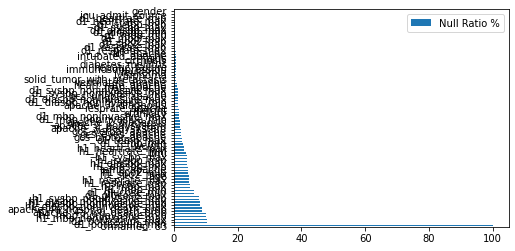

['Unnamed: 83']

In [5]:
def plot_nas(training_X: pd.DataFrame, threshold, use_treshold):
    to_delete = []
    if training_X.isnull().sum().sum() != 0:
        na_training_X = (training_X.isnull().sum() / len(training_X)) * 100
        na_training_X = na_training_X.drop(na_training_X[na_training_X == 0].index).sort_values(ascending=False)
        to_delete = na_training_X[na_training_X > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_training_X})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,20)

        if use_treshold:
            plt.axvline(x=50, color='red')
            plt.text(45,-1,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
    return to_delete.index.tolist()
        

plot_nas(dataset,50,False)

Analizzando la distribuzione delle varie features possiamo vedere come il dataset sia di buona qualità, avendo pochi campi non nulli. Tuttavia la feature ```unnamed83``` presenta soltanto campi nulli, e quindi verrà eliminata in una successiva fase di pulizia del dataset.

Per le restanti features si sceglie di mantenere quelle che presentano una soglia di valori NaN superiore al 20%, motivo per cui non ce n'è nessuna da scartare. Si può quindi procedere con una fase imputazione di tali dati mancanti, senza introdurre un rumore eccessivo nel dataset. 

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [6]:
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
mapping = []

for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):
            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)
mapped_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  int64  
 12  icu_type                       91713 non-null 

Visualizziamo il mapping effettuato delle variabili categoriche.

- _NOTA_: I valori NaN risultano mappati nel dizionario, ma tramite la clausola ```where(~dataset.isna(), dataset)``` ristabiliamo i valori NaN originali per la successiva fase di imputazione dei dati.

In [7]:
print(mapping)

[{0: 'African American', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Native American', 5: 'Other/Unknown', 6: nan}, {0: 'F', 1: 'M', 2: nan}, {0: 'Accident & Emergency', 1: 'Floor', 2: 'Operating Room / Recovery', 3: 'Other Hospital', 4: 'Other ICU', 5: nan}, {0: 'admit', 1: 'readmit', 2: 'transfer'}, {0: 'CCU-CTICU', 1: 'CSICU', 2: 'CTICU', 3: 'Cardiac ICU', 4: 'MICU', 5: 'Med-Surg ICU', 6: 'Neuro ICU', 7: 'SICU'}, {0: 'Cardiovascular', 1: 'Gastrointestinal', 2: 'Genitourinary', 3: 'Gynecological', 4: 'Hematological', 5: 'Metabolic', 6: 'Musculoskeletal/Skin', 7: 'Neurological', 8: 'Respiratory', 9: 'Sepsis', 10: 'Trauma', 11: nan}, {0: 'Cardiovascular', 1: 'Gastrointestinal', 2: 'Haematologic', 3: 'Metabolic', 4: 'Neurologic', 5: 'Renal/Genitourinary', 6: 'Respiratory', 7: 'Trauma', 8: 'Undefined Diagnoses', 9: 'Undefined diagnoses', 10: nan}]


Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```float64```, oggetto che accetta valori interi nulli.

In [8]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [9]:
mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  float64
 7   gender                         91688 non-null  float64
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  float64
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  int64  
 12  icu_type                       91713 non-null 

## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il paziente sopravvive o muore). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

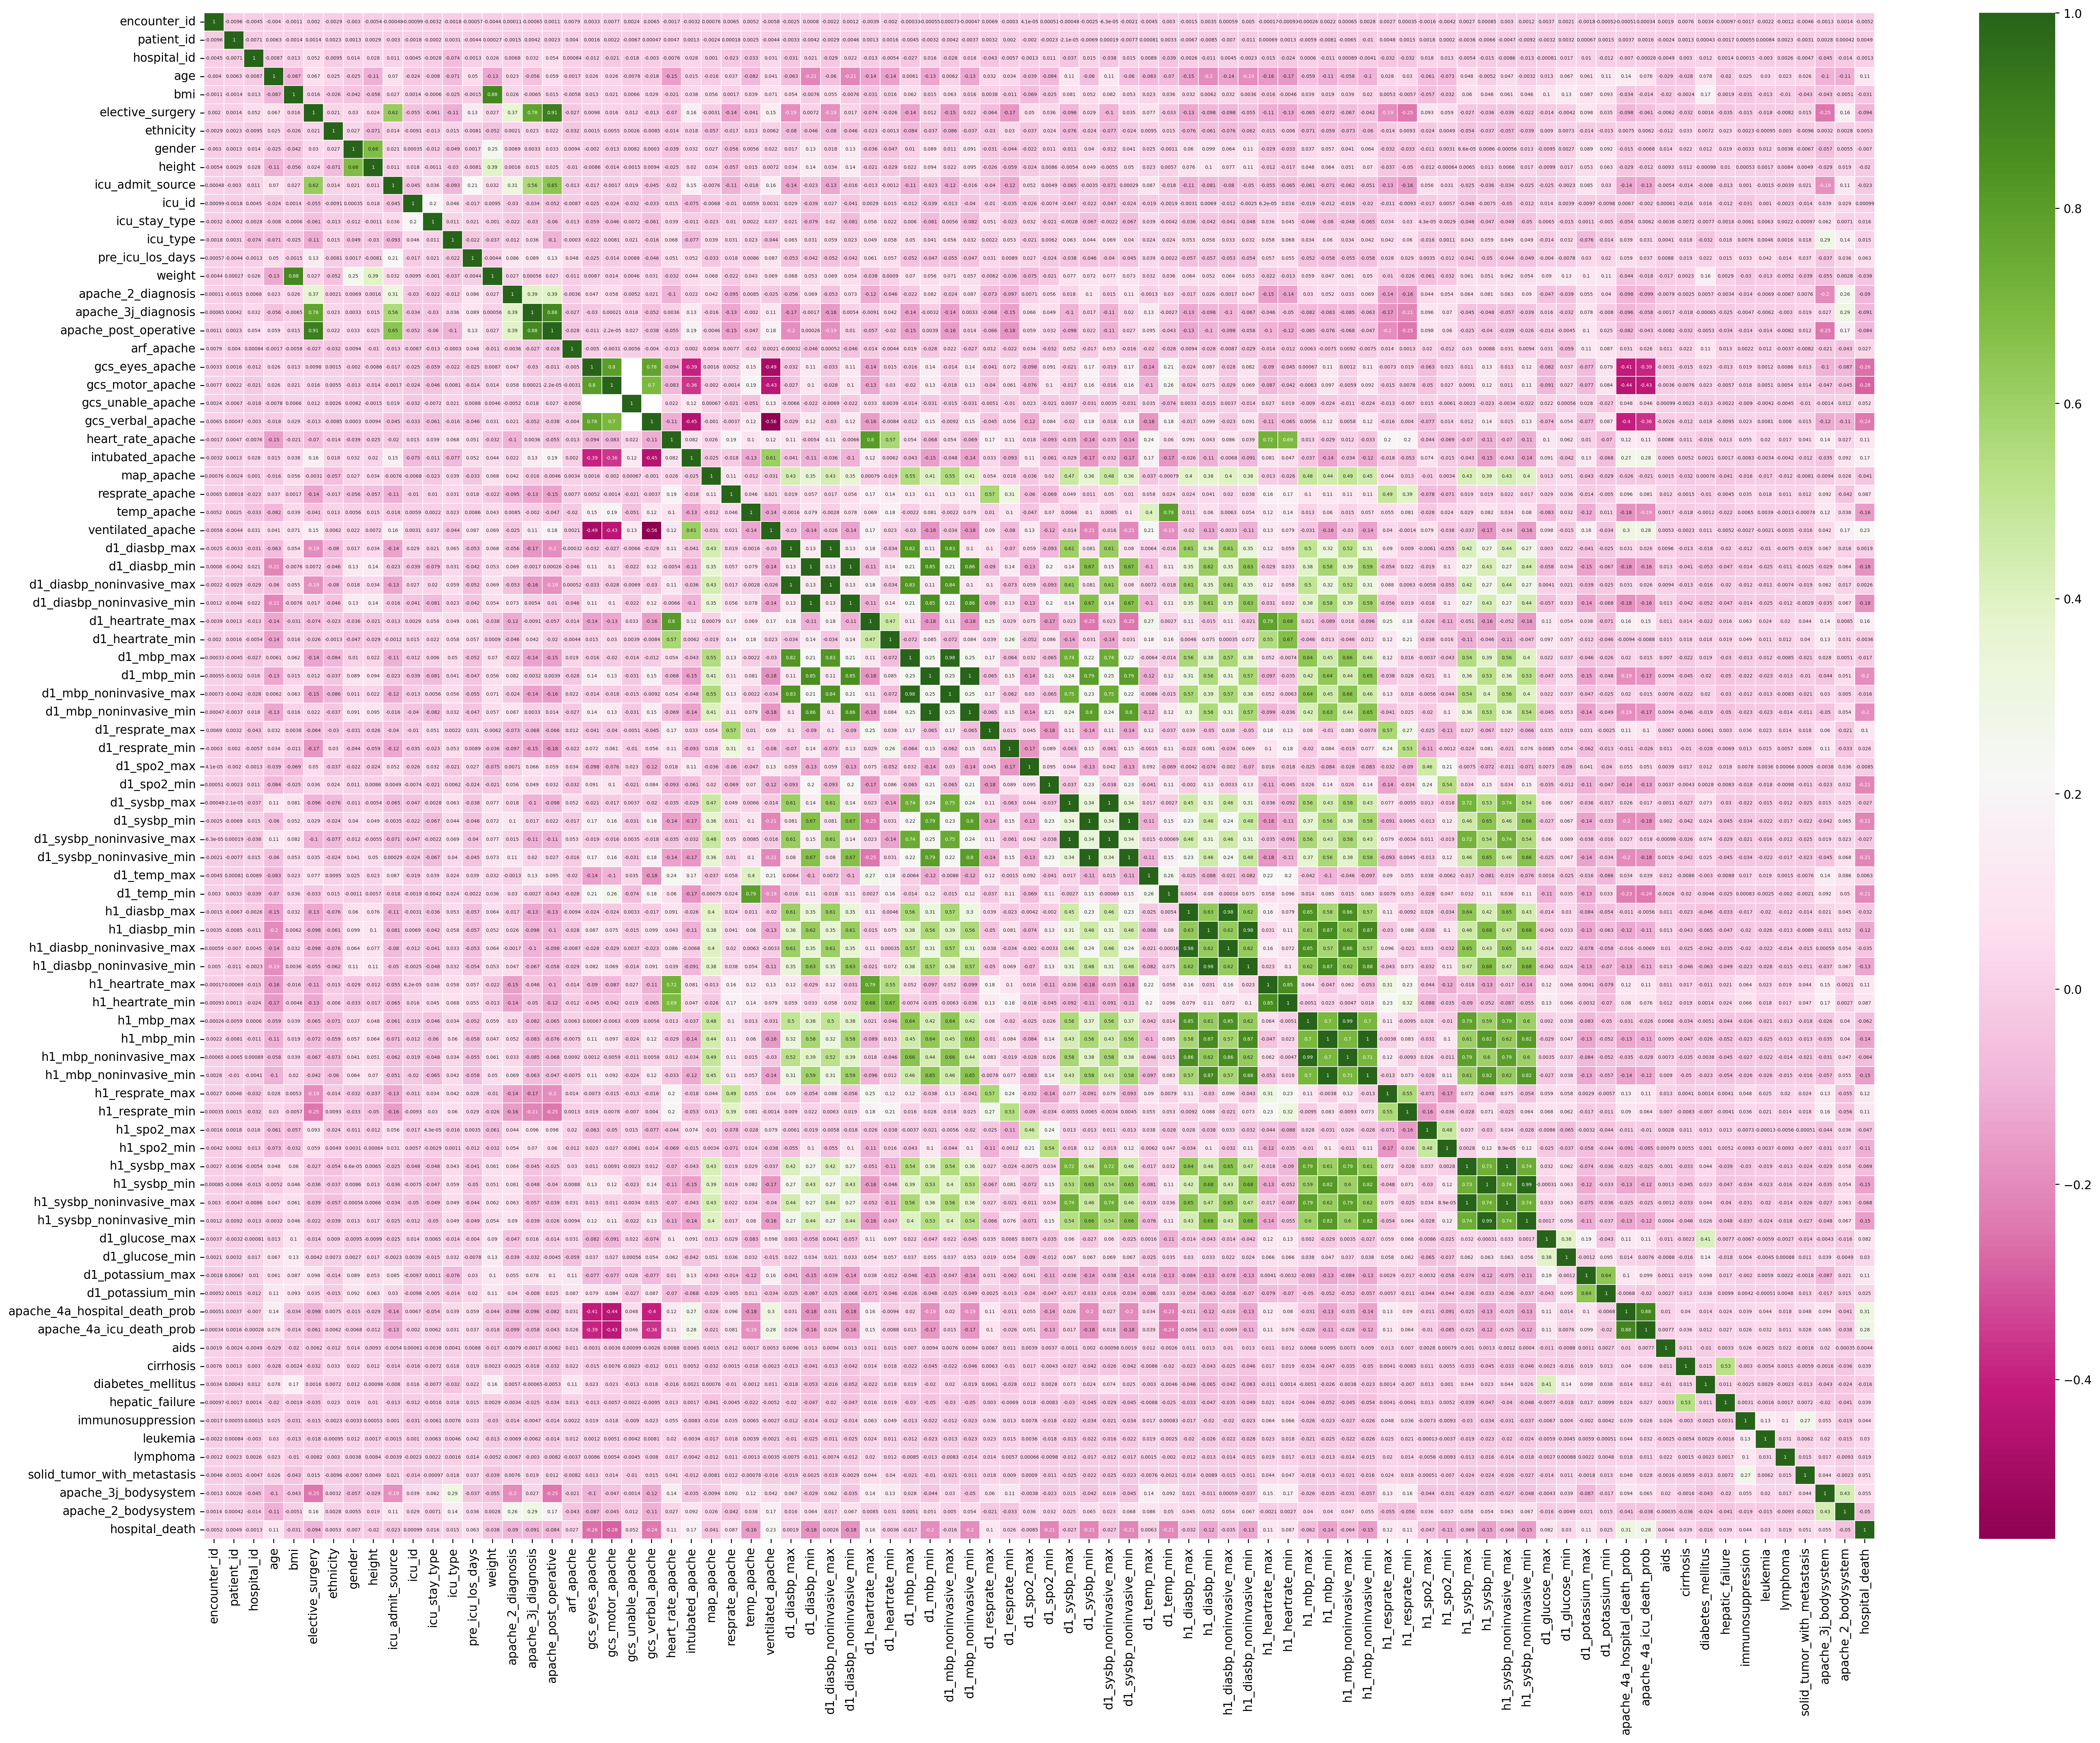

In [13]:
plt.figure(figsize=(32,24), dpi=250)
correlation_matrix = mapped_dataset.corr()
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG", annot=True, annot_kws={"fontsize":4})
plt.yticks(rotation=0)
plt.show()

# Training & Test Set Splitting

Andiamo a splittare il dataset in training e testing set utilizzando come percentuali 80/20.

In [10]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet: {}".format(trainX.shape))
print("TestingSet: {}".format(testX.shape))

TrainingSet: (73370, 84)
TestingSet: (18343, 84)


# Results on Original Dataset

Andiamo a misurare le prestazioni di vari classificatori sul dataset originale, quindi senza ingegneria delle features e imputazione dei valori mancanti. 
- I classificatori considerati non gestiscono in modo automatico i valori ```NaN```
- Per eseguire la classificazione è comunque necessario mappare i valori ```NaN``` su un qualche valore numerico
- Si utilizza per questa fase di benchmark l'operatore ```fillna(-1)``` sostituendo quindi ```NaN``` con ```-1```

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

def run_classifications(train_X, train_Y, test_X, test_Y, fill, matrix):
    if fill:
        train_X = train_X.fillna(-1)
        test_X = test_X.fillna(-1)
    
    lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo
    rdt = DecisionTreeClassifier()
    gnb = GaussianNB()

    rdt.fit(train_X, train_Y)
    lr.fit(train_X, train_Y)
    gnb.fit(train_X, train_Y)

    # TODO altri classificatori in una lista e cose varie
    lr_targets_predicted = lr.predict(test_X)
    rdt_targets_predicted = rdt.predict(test_X)
    gnb_targets_predicted = gnb.predict(test_X)

    print("Logistic Regression Classifier report: \n\n", classification_report(test_Y, lr_targets_predicted))
    print("Decision Tree Classifier report: \n\n", classification_report(test_Y, rdt_targets_predicted))
    print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(test_Y, gnb_targets_predicted))

    if matrix:
        cm = confusion_matrix(test_Y, lr_targets_predicted)
        x_axis_labels = ["Survived", "Dead"]
        y_axis_labels = ["Survived", "Dead"]
        f, ax = plt.subplots(figsize =(7,7))
        sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        plt.xlabel("PREDICTED LABEL")
        plt.ylabel("TRUE LABEL")
        plt.title('Confusion Matrix for Logistic Regression Classifier')
        plt.show()

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.99      0.96     16672
           1       0.65      0.16      0.25      1671

    accuracy                           0.92     18343
   macro avg       0.79      0.57      0.60     18343
weighted avg       0.90      0.92      0.89     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.93      0.93     16672
           1       0.35      0.36      0.36      1671

    accuracy                           0.88     18343
   macro avg       0.64      0.65      0.64     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.95      0.87      0.91     16672
           1       0.28      0.50      0.36      1671

    accuracy                           0.84     18343
   macr

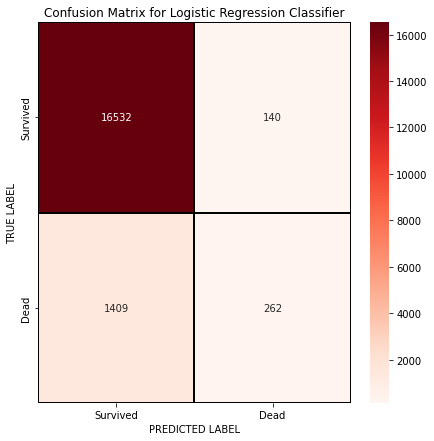

In [13]:
# usiamo una copia di training e test set così da mantenerli puliti quelli originali per l'imputazione successiva
train_X = trainX.copy()
test_X = testX.copy()
run_classifications(train_X, trainY, test_X, testY, fill = True, matrix = True)

# Training Set Cleaning

Andiamo ad eseguire diverse operazioni per rimuovere rumore dal dataset
- Rimozione features nulle e con bassa varianza
- Feature Selection
- PCA
- Data Imputation

## Rimozione features nulle e con bassa varianza

In [14]:
from sklearn.feature_selection import VarianceThreshold

# accetta valori NaN, per cui deriviamo due nuovi training e test set a partire da quelli originali
selector = VarianceThreshold(threshold=0.01)
train = pd.DataFrame(selector.fit_transform(trainX))
dropped = [column for column in trainX.columns 
            if column not in trainX.columns[selector.get_support()]]

# restore column names
train.columns = [column for column in trainX.columns 
            if column not in dropped]

for features in dropped:
    print(features)

test = testX.copy()
test = test.drop(columns = dropped)

gcs_unable_apache
aids
leukemia
lymphoma
Unnamed: 83


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73370 entries, 0 to 73369
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   73370 non-null  float64
 1   patient_id                     73370 non-null  float64
 2   hospital_id                    73370 non-null  float64
 3   age                            70023 non-null  float64
 4   bmi                            70633 non-null  float64
 5   elective_surgery               73370 non-null  float64
 6   ethnicity                      72237 non-null  float64
 7   gender                         73350 non-null  float64
 8   height                         72291 non-null  float64
 9   icu_admit_source               73279 non-null  float64
 10  icu_id                         73370 non-null  float64
 11  icu_stay_type                  73370 non-null  float64
 12  icu_type                       73370 non-null 

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18343 entries, 64436 to 16344
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   18343 non-null  int64  
 1   patient_id                     18343 non-null  int64  
 2   hospital_id                    18343 non-null  int64  
 3   age                            17462 non-null  float64
 4   bmi                            17651 non-null  float64
 5   elective_surgery               18343 non-null  int64  
 6   ethnicity                      18081 non-null  float64
 7   gender                         18338 non-null  float64
 8   height                         18088 non-null  float64
 9   icu_admit_source               18322 non-null  float64
 10  icu_id                         18343 non-null  int64  
 11  icu_stay_type                  18343 non-null  int64  
 12  icu_type                       18343 non-n

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.99      0.96     16672
           1       0.66      0.16      0.26      1671

    accuracy                           0.92     18343
   macro avg       0.79      0.58      0.61     18343
weighted avg       0.90      0.92      0.89     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.93      0.93     16672
           1       0.34      0.36      0.35      1671

    accuracy                           0.88     18343
   macro avg       0.64      0.64      0.64     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.95      0.87      0.91     16672
           1       0.28      0.50      0.36      1671

    accuracy                           0.84     18343
   macr

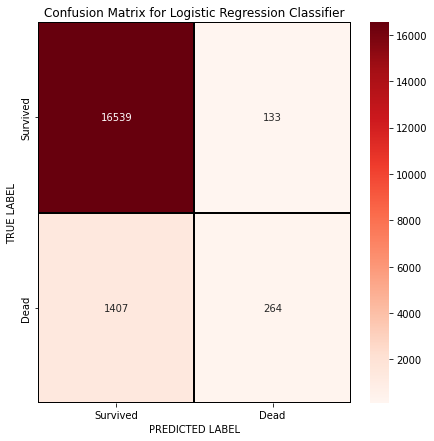

In [17]:
run_classifications(train, trainY, test, testY, fill = True, matrix = True)

## Feature Selection

Prova con feature selection

In [18]:
import statsmodels.api as sm

Selected_Features = []

def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")

In [19]:
# applicata su una copia del training set originale
train = trainX.copy()
test = testX.copy()
backward_regression(train.fillna(-1), trainY)

worst_feature : h1_resprate_max, 0.982672274714085 
worst_feature : d1_sysbp_noninvasive_min, 0.9776880422158314 
worst_feature : hospital_id, 0.9471681344571521 
worst_feature : d1_mbp_noninvasive_max, 0.8676112498545989 
worst_feature : h1_diasbp_min, 0.7929662272931688 
worst_feature : apache_post_operative, 0.7494265300245236 
worst_feature : h1_diasbp_noninvasive_max, 0.6912687985481183 
worst_feature : weight, 0.6407035816389586 
worst_feature : h1_sysbp_min, 0.5668616359325387 
worst_feature : icu_id, 0.5084454257319644 
worst_feature : d1_diasbp_noninvasive_min, 0.4780161916296932 
worst_feature : d1_mbp_noninvasive_min, 0.5878984479599184 
worst_feature : patient_id, 0.39251308877119284 
worst_feature : d1_sysbp_max, 0.3379637246085231 
worst_feature : d1_mbp_max, 0.3983097117988089 
worst_feature : h1_mbp_max, 0.12287876210859909 
worst_feature : h1_mbp_min, 0.5243353676228133 
worst_feature : h1_mbp_noninvasive_max, 0.4921099361754242 
worst_feature : h1_sysbp_noninvasive_mi

Prova con la feature selection a casaccio

In [22]:
dropped = [column for column in train.columns 
            if column not in Selected_Features[0]]

print("Removed column after backward regression\n")
for features in dropped:
    print(features)

train = train.drop(columns = dropped)
test = test.drop(columns = dropped)

Removed column after backward regression

patient_id
hospital_id
icu_id
weight
apache_post_operative
d1_diasbp_noninvasive_min
d1_mbp_max
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_sysbp_max
d1_sysbp_noninvasive_min
h1_diasbp_min
h1_diasbp_noninvasive_max
h1_mbp_max
h1_mbp_min
h1_mbp_noninvasive_max
h1_resprate_max
h1_sysbp_min
h1_sysbp_noninvasive_min
leukemia


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73370 entries, 29631 to 68268
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   73370 non-null  int64  
 1   age                            70023 non-null  float64
 2   bmi                            70633 non-null  float64
 3   elective_surgery               73370 non-null  int64  
 4   ethnicity                      72237 non-null  float64
 5   gender                         73350 non-null  float64
 6   height                         72291 non-null  float64
 7   icu_admit_source               73279 non-null  float64
 8   icu_stay_type                  73370 non-null  int64  
 9   icu_type                       73370 non-null  int64  
 10  pre_icu_los_days               73370 non-null  float64
 11  apache_2_diagnosis             72047 non-null  float64
 12  apache_3j_diagnosis            72507 non-n

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18343 entries, 64436 to 16344
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   18343 non-null  int64  
 1   age                            17462 non-null  float64
 2   bmi                            17651 non-null  float64
 3   elective_surgery               18343 non-null  int64  
 4   ethnicity                      18081 non-null  float64
 5   gender                         18338 non-null  float64
 6   height                         18088 non-null  float64
 7   icu_admit_source               18322 non-null  float64
 8   icu_stay_type                  18343 non-null  int64  
 9   icu_type                       18343 non-null  int64  
 10  pre_icu_los_days               18343 non-null  float64
 11  apache_2_diagnosis             18004 non-null  float64
 12  apache_3j_diagnosis            18105 non-n

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.99      0.96     16672
           1       0.65      0.16      0.26      1671

    accuracy                           0.92     18343
   macro avg       0.79      0.58      0.61     18343
weighted avg       0.90      0.92      0.89     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93     16672
           1       0.34      0.35      0.35      1671

    accuracy                           0.88     18343
   macro avg       0.64      0.64      0.64     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     16672
           1       0.31      0.44      0.36      1671

    accuracy                           0.86     18343
   macr

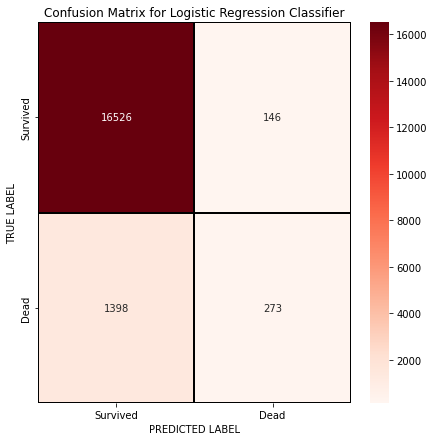

In [25]:
run_classifications(train, trainY, test, testY, fill = True, matrix = True)

## PCA

## Data Imputation

Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti delle diverse features del dataset. L'obiettivo è quello di ripristinare le diverse variabili per l'uso nella classificazione rimpiazzando tutti i dati nulli con valori derivati da entry simili nel dataset.

In [20]:
# sto riusando training originale non so di preciso se dobbiamo applicarlo diretto a quello filtrato dopo la feature selection penso di si
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73370 entries, 29631 to 68268
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   73370 non-null  int64  
 1   patient_id                     73370 non-null  int64  
 2   hospital_id                    73370 non-null  int64  
 3   age                            70023 non-null  float64
 4   bmi                            70633 non-null  float64
 5   elective_surgery               73370 non-null  int64  
 6   ethnicity                      72237 non-null  float64
 7   gender                         73350 non-null  float64
 8   height                         72291 non-null  float64
 9   icu_admit_source               73279 non-null  float64
 10  icu_id                         73370 non-null  int64  
 11  icu_stay_type                  73370 non-null  int64  
 12  icu_type                       73370 non-n

Prova al volo mantenendo solo ste quattro colonne

In [9]:
trainX = trainX.filter(["ethnicity", "height", "weight", "arf_apache"])
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73370 entries, 29631 to 68268
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ethnicity   72237 non-null  float64
 1   height      72291 non-null  float64
 2   weight      71215 non-null  float64
 3   arf_apache  72815 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


In [10]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
impTrain = pd.DataFrame(imp.fit_transform(trainX), columns = trainX.columns)
impTrain.info()

ethnicity  height  weight  arf_apache
2.0        183.00  107.0   0.0           418
           177.80  79.4    0.0           125
           172.70  97.3    0.0           115
           170.20  65.8    0.0           109
           167.60  62.1    0.0           106
                                        ... 
           162.50  86.3    0.0             1
                   86.1    0.0             1
                   85.7    0.0             1
                   85.5    0.0             1
5.0        195.59  151.0   0.0             1
Length: 40698, dtype: int64
